In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from rapidfuzz import process, fuzz
import random
import matplotlib.pyplot as plt

random.seed(0)

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

def get_best_match_rapid(query, choices, scorer=fuzz.WRatio):
    result = process.extractOne(query, choices, scorer=scorer)
    return result[0] if result else None

def ingredients_to_binary(ingredient_string, df_ingredients):
    ingredients_binary = [0] * len(df_ingredients)
    queries = ingredient_string.split(', ')
    
    for query in queries:
        query = query.lower().strip()
        best_match = get_best_match_rapid(query, df_ingredients)
        if best_match:
            index = df_ingredients.index(best_match)
            ingredients_binary[index] = 1

    return ingredients_binary

def get_columns_with_ones(df, row_index):
    condition = df.iloc[row_index] == 1
    return df.columns[condition].tolist()

def get_recipes(df, similarity_matrix, top_n=30):
    top_indices = np.argsort(similarity_matrix.flatten())[-top_n:][::-1]
    recipes = [df.iloc[index]['recipename'] for index in top_indices]
    ingredients = [get_columns_with_ones(df, index) for index in top_indices]
    return recipes, ingredients

def rank_recipes_by_cuisine(recipes, ingredients, cluster_df, selected_cuisine, top_n=5):
    df = pd.DataFrame({'recipename': recipes, 'Ingredients': ingredients})
    df['recipename'] = df['recipename'].astype(str)  # Ensure the key for merging is of type str

    # Merge the recipe DataFrame with the cluster DataFrame on the 'recipename' column
    merged_df = df.merge(cluster_df, on='recipename', how='left')

    # Use the selected_cuisine as a column name to access the concentration scores
    # Assume higher scores indicate higher relevance to the cuisine
    merged_df['score'] = merged_df[selected_cuisine]  # This line assumes `selected_cuisine` directly matches a column name in `cluster_df`
    filtered_df = merged_df.sort_values(by='score', ascending=False).head(top_n)  # Sort by score descending

    return filtered_df['recipename'].tolist(), filtered_df['Ingredients'].tolist()


def evaluate_relevance(input_ingredients, recommended_ingredients):
    common_ingredients = set(input_ingredients) & set(recommended_ingredients)
    return len(common_ingredients) >= 2

def evaluate_metrics(ground_truths, predictions, total_relevant):
    true_positives = sum(ground_truths)
    precision = true_positives / len(predictions) if predictions else 0
    recall = true_positives / total_relevant if total_relevant else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1_score

def total_relevant_recipes(df, ingredient_input, cuisine_style):
    total_relevant = 0
    input_ingredients = set(ingredient_input.split(', '))
    for index, row in df.iterrows():
        recipe_ingredients = set(get_columns_with_ones(df, index))
        if row['cuisine'].lower() == cuisine_style.lower() and len(input_ingredients & recipe_ingredients) >= 2:
            total_relevant += 1
    return total_relevant

In [29]:
# Load data
data = pd.read_csv('../recipe_ingredients_dataset/ingredient_df_with_recipenames.csv')

# Get list of unique ingredients and cuisine styles from the dataset
unique_ingredients = [col for col in data.columns if col not in ['id', 'cuisine', 'recipename']]
cuisine_styles = data['cuisine'].unique().tolist()  # Assuming 'cuisine' is a column with categorical data

# Load in SVD Matrices 
vmatrix = pd.read_csv('../recipe_ingredients_dataset/V_1000matrix.csv',index_col=0)
umatrix = pd.read_csv('../recipe_ingredients_dataset/U_1000matrix.csv',index_col=0)

cluster = pd.read_csv('../recipe_ingredients_dataset/pca_clusters.csv',index_col=0)

# Ingredient inputs and assigned cuisine styles
ingredient_inputs = [
    "butter, onions, bacon",
    "flour, eggs, milk, sugar",
    "chocolate, vanilla, salt, baking powder, eggs",
    "chicken, garlic, paprika, lemon",
    "beef, pepper, salt, rosemary, thyme",
    "carrots, peas, corn, tomatoes, cucumber",
    "pork, bbq sauce, vinegar, sugar, mustard",
    "shrimp, lemon, garlic, parsley, butter",
    "salmon, dill, lemon, garlic, olive oil, pepper",
]

In [37]:
precisions, recalls, f1_scores = [], [], []

for ingredients, cuisine_style in zip(ingredient_inputs, cuisine_styles):
    binary = ingredients_to_binary(ingredients, unique_ingredients)
    xcon = pd.Series(binary).dot(vmatrix)
    xcon = np.array(xcon).reshape(1, -1)
    similarities = pairwise_distances(umatrix, xcon, metric='cosine')
    recommended_recipes, recommended_ingredients = get_recipes(data, 1 - similarities.flatten())

    # Rank recipes by cuisine and get top recommendations
    final_recipes, final_ingredients = rank_recipes_by_cuisine(recommended_recipes, recommended_ingredients, cluster, cuisine_style, top_n=5)

    # Determine the total number of relevant recipes in the dataset
    total_relevant = total_relevant_recipes(data, ingredients, cuisine_style)

    # Generate relevances for ranked recommendations
    relevances = [evaluate_relevance(ingredients.split(', '), rec_ing) for rec_ing in final_ingredients]
    predictions = [True] * len(final_recipes)  # Assume all predicted as relevant for precision calculation

    # Calculate and store evaluation metrics
    precision, recall, f1_score = evaluate_metrics(relevances, predictions, total_relevant)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

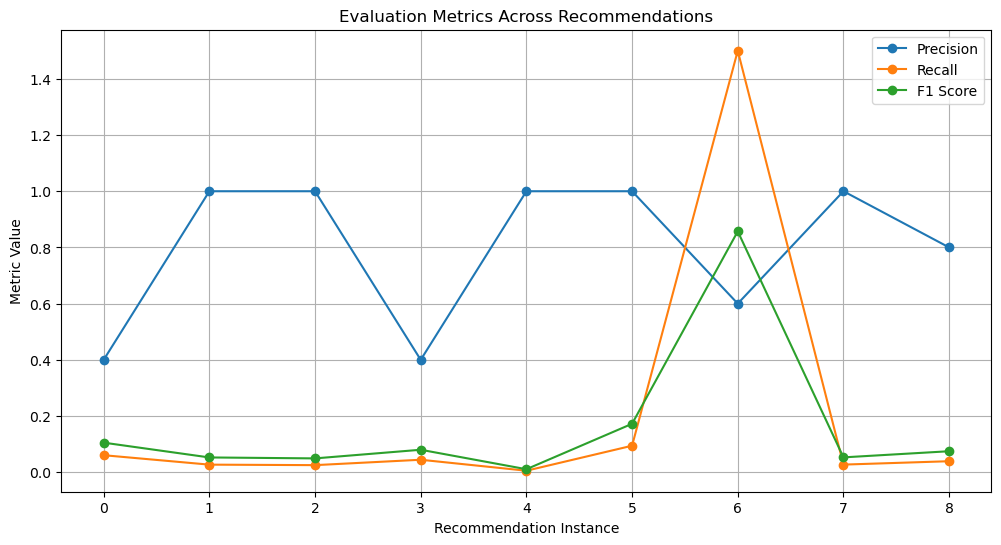

In [38]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(precisions, label='Precision', marker='o')
plt.plot(recalls, label='Recall', marker='o')
plt.plot(f1_scores, label='F1 Score', marker='o')
plt.title('Evaluation Metrics Across Recommendations')
plt.xlabel('Recommendation Instance')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
precisions

[0.4, 1.0, 1.0, 0.4, 1.0, 1.0, 0.6, 1.0, 0.8]

In [40]:
recalls

[0.06060606060606061,
 0.02702702702702703,
 0.025252525252525252,
 0.044444444444444446,
 0.005393743257820928,
 0.09433962264150944,
 1.5,
 0.02717391304347826,
 0.0392156862745098]

In [42]:
f1_scores

[0.10526315789473685,
 0.052631578947368425,
 0.04926108374384236,
 0.07999999999999999,
 0.010729613733905581,
 0.1724137931034483,
 0.857142857142857,
 0.05291005291005291,
 0.07476635514018691]

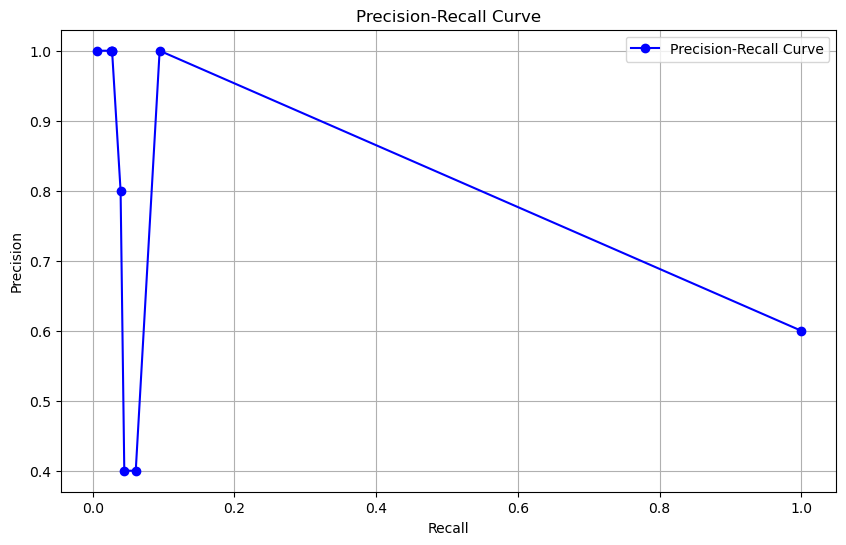

In [43]:
# Correcting any recall values greater than 1 (not likely needed here but good to have)
recalls = [min(r, 1) for r in recalls]

# Combine the lists into a single list of tuples
combined = list(zip(recalls, precisions))

# Sort the list of tuples by the recall values (first item in the tuples)
combined_sorted = sorted(combined, key=lambda x: x[0])

# Separate the combined list back into two lists
sorted_recalls, sorted_precisions = zip(*combined_sorted)

# Plotting the Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(sorted_recalls, sorted_precisions, marker='o', linestyle='-', color='b', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
sorted_recalls

(0.005393743257820928,
 0.025252525252525252,
 0.02702702702702703,
 0.02717391304347826,
 0.0392156862745098,
 0.044444444444444446,
 0.06060606060606061,
 0.09433962264150944,
 1)

In [46]:
sorted_precisions

(1.0, 1.0, 1.0, 1.0, 0.8, 0.4, 0.4, 1.0, 0.6)

In [47]:
def suppress_values(lst):
    """
    This function takes a list of numbers and modifies it in place.
    Any number in the list greater than 1 is replaced with 1.
    
    Args:
    lst (list of float or int): The list to be modified.
    
    Returns:
    list: The modified list where all elements greater than 1 are now 1.
    """
    return [1 if x > 1 else x for x in lst]

In [49]:
f = suppress_values(f1_scores)
r = suppress_values(recalls)
p = suppress_values(precisions)

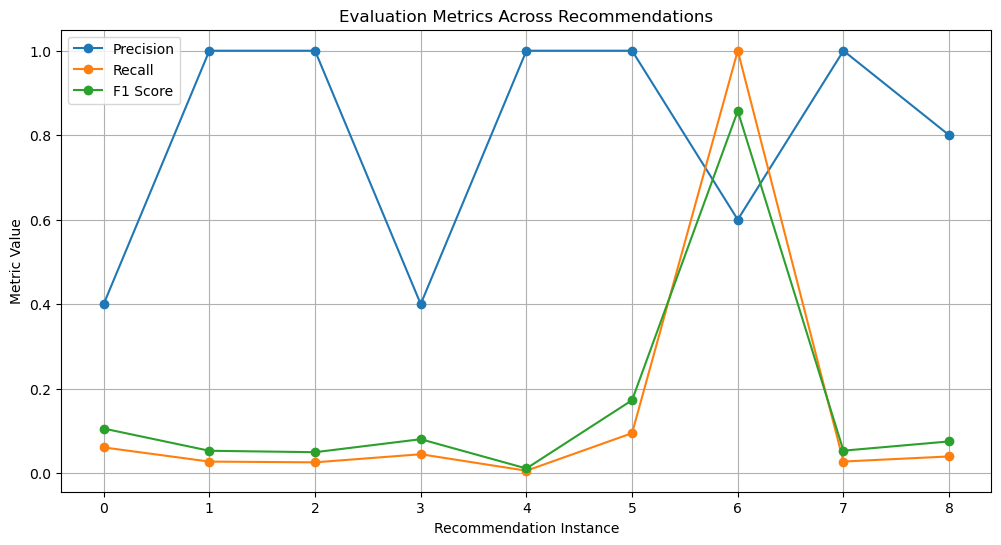

In [50]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(p, label='Precision', marker='o')
plt.plot(r, label='Recall', marker='o')
plt.plot(f, label='F1 Score', marker='o')
plt.title('Evaluation Metrics Across Recommendations')
plt.xlabel('Recommendation Instance')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Creating the DataFrame
data = {'Precision': p, 'Recall': r, 'F1 Score': f}
df = pd.DataFrame(data)

df

,Precision,Recall,F1 Score
0,0.4,0.060606,0.105263
1,1.0,0.027027,0.052632
2,1.0,0.025253,0.049261
3,0.4,0.044444,0.080000
4,1.0,0.005394,0.010730
5,1.0,0.094340,0.172414
6,0.6,1.000000,0.857143
7,1.0,0.027174,0.052910
8,0.8,0.039216,0.074766


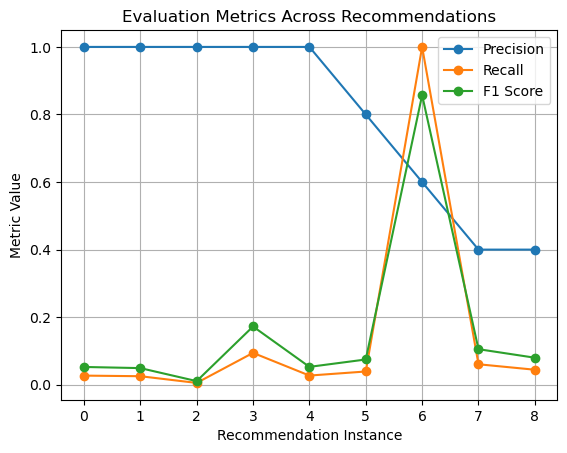

In [52]:
sorted_df.reset_index(drop=True, inplace=True)

plt.plot(sorted_df['Precision'], label='Precision', marker='o')
plt.plot(sorted_df['Recall'], label='Recall', marker='o')
plt.plot(sorted_df['F1 Score'], label='F1 Score', marker='o')

plt.title('Evaluation Metrics Across Recommendations')
plt.xlabel('Recommendation Instance')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()